<center> <b> <font size="+2"> DIGIT CLASSIFICATION </font> </b> </center> 

Michał Thor, Bartłomiej Kowalczuk  

In this project we wanted to created digit classifier that would be trained on data published on https://github.com/kensanata/numbers.  
Using that data we created a dataset that consits of 10.000 images, all rescaled to 28x28 resolution, all in grayscale.

We used Support Vector Machines algorithm, which scored <b>92%</b> accuracy on the test set.  
Then we used Convolutional Neural Network, which we tuned to gave us almost <b>99%</b> accuracy.

In [1]:
# testing if there are available gpu's to train the network on
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


## Import libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from subprocess import check_output
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


### Displaying sample image

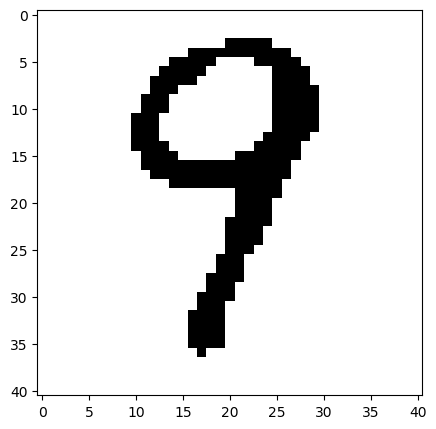

In [96]:
plt.figure(figsize=(10,5))
pic = Image.open(f'data/9/number-0000000.png').convert('RGB')
plt.imshow(pic)

## Data preparation

(don't run the code, dataset is already prepared)

In [87]:
def data_prepare(digit = 0):
    image_list = []
    for file in glob.glob(f"data/{digit}/*.PNG"):
        pic = Image.open(file).convert('L')
        img = pic.resize((28,28), Image.ANTIALIAS)
        pix = np.array(img)
        flat_arr = pix.ravel()
        image_list.append(flat_arr)
    if len(image_list) < 1000:
        print("Something is wrong with the image list")
    # adding label to matrix row
    image_list_y = [np.insert(item,0,digit,axis=0) for item in image_list]
    images_matrix = np.array(image_list_y)
    if images_matrix.shape != (1000, 785):
        print("Something is wrong with matrix shape")
    else:
        print(digit, images_matrix.shape)
    
    return images_matrix

In [ ]:
# using data_prepare function for all digits (subfolders)
for digit in range(0,10):
    if digit == 0:
        im = data_prepare(digit)
    else:
        im_temp = data_prepare(digit)
        im = np.concatenate((im, im_temp), axis=0)

In [ ]:
# saving to csv
df_array = pd.DataFrame(im)
df_array.to_csv("df.csv")

## Load the dataset

In [2]:
#loading the dataset.......(Train)
df = pd.read_csv("df.csv")
print(df.shape)
df = df.drop(["Unnamed: 0"], axis = 1)
df.columns.values[0] = 'label'
df.head(3)
print("Any missing sample in the dataset:",df.isnull().values.any())

(10000, 786)
Any missing sample in the dataset: False


### Splitting into train/test

In [3]:
train, test = train_test_split(df, test_size=0.2)

In [4]:
num_classes = 10
# casting values as numeric (making sure they are int/float)
x_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
x_test = test.iloc[:,1:].values.astype('float32')
y_test = test.iloc[:,0].values.astype('int32')
# y_test = keras.utils.to_categorical(y_test, num_classes)

### Preview the images

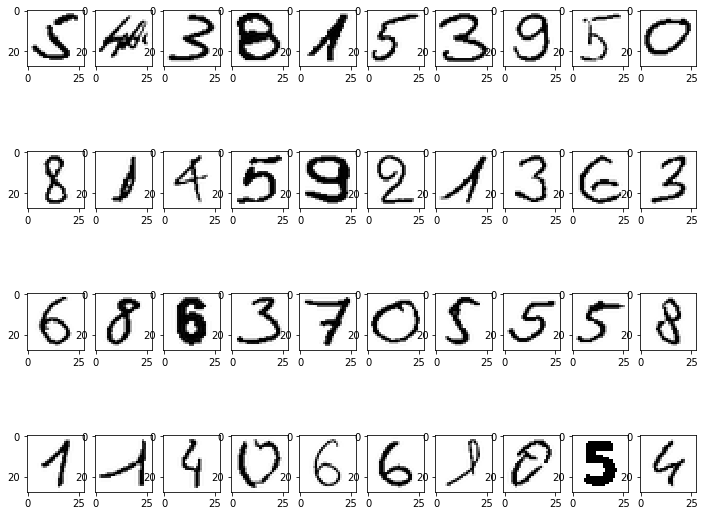

In [6]:
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest', cmap="gray")
plt.show()

### Normalise data

In [5]:
# all values are between 0 an 1
x_train = x_train/255.0
x_test = x_test/255.0

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8000, 784)
8000 train samples
2000 test samples


### Reshaping

In [7]:
X_train = x_train.reshape(x_train.shape[0], 784)
X_test = x_test.reshape(x_test.shape[0], 784)

***

> # SVM 

In [62]:
# SVM cross validation
names_of_predictors = list(df.iloc[:,1:].columns.values)

# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'],
                'gamma': [1e-3, 1e-4],
                'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'],
                'C': [1, 10, 100, 1000]}]

In [63]:
# Scaling the Train and Test feature set 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<center> <font color=red size="+1"> <b>  WARNING GRIDSEARCH MAY TAKE MORE THAN 30 MIN </b> </font> <center>

In [ ]:
# Performing Cross Validation to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

In [ ]:
print('Best score for training data:', svm_model.best_score_) # 0.899875 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) # 10 
print('Best Kernel:',svm_model.best_estimator_.kernel) # rbf
print('Best Gamma:',svm_model.best_estimator_.gamma) # 0.001

In [8]:
svm_model_linear = SVC(C=10,
                       cache_size=200,
                       class_weight=None,
                       coef0=0.0,
                       decision_function_shape='ovr',
                       degree=3,
                       gamma= 0.001,
                       kernel='rbf',
                       max_iter=-1,
                       probability=False,
                       random_state=None,
                       shrinking=True,
                       tol=0.001,
                       verbose=False).fit(X_train, y_train) 

svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy_svm = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm_svm = confusion_matrix(y_test, svm_predictions) 

In [9]:
print(cm_svm)
print(accuracy_svm)

[[194   0   1   0   2   1   2   0   1   2]
 [  0 189   3   0   3   1   0   0   0   2]
 [  1   4 174   4   0   4   0   0   0   0]
 [  0   2   5 183   0   8   0   0   5   7]
 [  2   8   1   0 198   0   5   1   0   0]
 [  1   3   1   6   1 159   2   0   3   1]
 [  0   1   1   0   3   1 202   0   1   0]
 [  0   3   1   0   2   0   0 179   0   5]
 [  1   8   3   1   1   3   0   1 176   5]
 [  0   3   0   4   3   4   0   6   8 184]]
0.919


In [10]:
print(classification_report(y_test, svm_predictions))

print("Training set score for SVM: %f" % svm_model_linear.score(X_train , y_train))
print("Testing  set score for SVM: %f" % svm_model_linear.score(X_test  , y_test ))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       203
           1       0.86      0.95      0.90       198
           2       0.92      0.93      0.92       187
           3       0.92      0.87      0.90       210
           4       0.93      0.92      0.93       215
           5       0.88      0.90      0.89       177
           6       0.96      0.97      0.96       209
           7       0.96      0.94      0.95       190
           8       0.91      0.88      0.90       199
           9       0.89      0.87      0.88       212

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Training set score for SVM: 0.949750
Testing  set score for SVM: 0.919000


***

> # CNN

In [ ]:
# reshaping for cnn
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

In [10]:
# base hyperparameters
batch_size = 100 # 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

In [11]:
# convert class vectors to binary class matrices (one hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split training into train and validation (for the network to learn on error in real time)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [13]:
# model architecture
model = Sequential()
# input layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
# output layer
model.add(Dense(num_classes, activation='softmax'))


# additional parameters and functions
opt = Adam(lr=0.01, decay = 0.01) 

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.RMSprop(),
              optimizer = opt,
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# es = EarlyStopping(monitor='loss', mode='min', verbose=1)

history = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [26]:
# model.summary()

<center> <font color=red size="+1"> <b> WARNING THE TRAINING PROCESS IN THE NEXT CELL IS FAST BUT IT TAKES A LOT OF COMPUTING POWER
    <br /> (AND THAT CAN DAMAGE YOUR COMPUTER) </b> </font> </center>

In [14]:
history.fit(X_train)
h = model.fit_generator(history.flow(X_train,Y_train,
                                     batch_size=batch_size),
                                     epochs = epochs,
                                     validation_data = (X_val,Y_val),
                                     verbose = 1,
                                     steps_per_epoch=X_train.shape[0] // batch_size,
                                     callbacks=[learning_rate_reduction],)
#                                      callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
72/72 [==============================] - 10s 144ms/step - loss: 1.5654 - acc: 0.4883 - val_loss: 2.9223 - val_acc: 0.2313
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.8413 - acc: 0.7375 - val_loss: 6.2812 - val_acc: 0.0963
Epoch 3/20
72/72 [==============================] - 5s 76ms/step - loss: 0.4838 - acc: 0.8567 - val_loss: 5.3732 - val_acc: 0.1087
Epoch 4/20
72/72 [==============================] - 5s 74ms/step - loss: 0.3971 - acc: 0.8811 - val_loss: 0.9391 - val_acc: 0.6637
Epoch 5/20
72/72 [==============================] - 5s 75ms/step - loss: 0.3355 - acc: 0.8967 - val_loss: 1.4771 - val_acc: 0.4638
Epoch 6/20
72/72 [==============================] - 5s 75ms/step - loss: 0.2809 - acc: 0.9203 - val_loss: 0.7270 - val_acc: 0.7200
Epoch 7/20
72/72 [==============================] - 5s 76ms/step - loss: 0.2343 - acc: 0.9354 - val_loss: 0.4779 - val_acc: 0.8412
Epoch 8/20
72/72 [===============

### CPU and GPU usage during training

CPU at peaks reached 92 deegrees, and GPU around 80 degrees.

![title](cpu_temp2.JPG)

![title](gpu_usage.JPG)

### Save model file

In [64]:
model.save('model_digits_2.h5')

### Load model file

In [1]:
# model = load_model('model_digits.h5')

### Loss (cost) and accuracy

In [18]:
# loss and accuracy on validation set (from training set)
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.088983, final accuracy: 0.977500


In [19]:
# print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

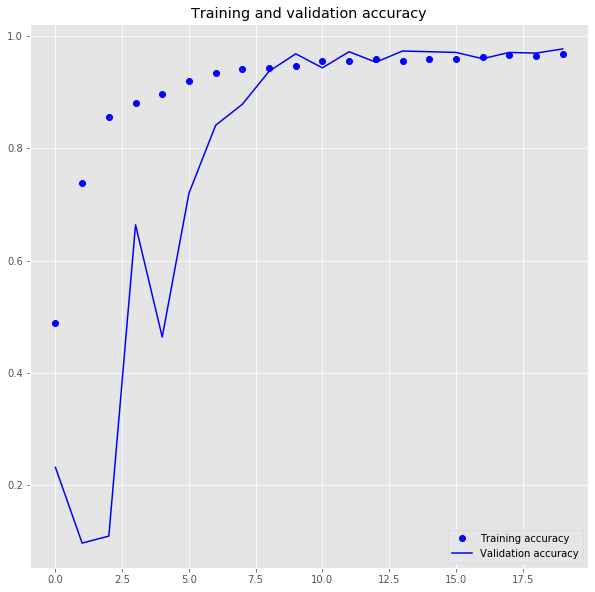

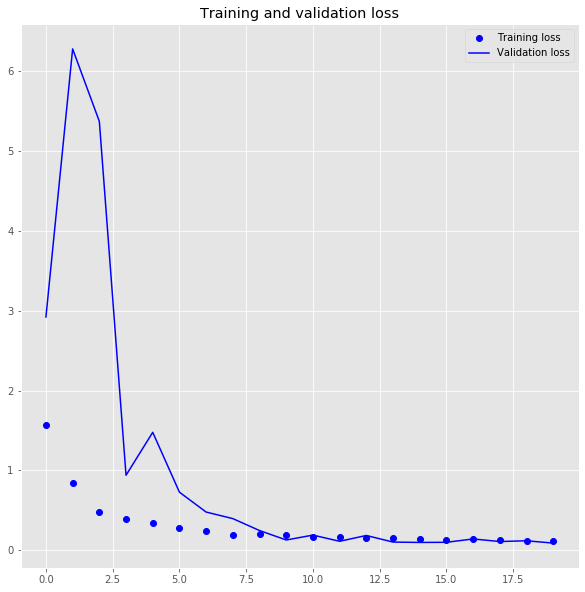

In [20]:
# accuracy
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
# plt.style.use(['dark_background'])
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

# loss
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Confusion matrix

In [32]:
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Confusion matrix for validation set (from training set)

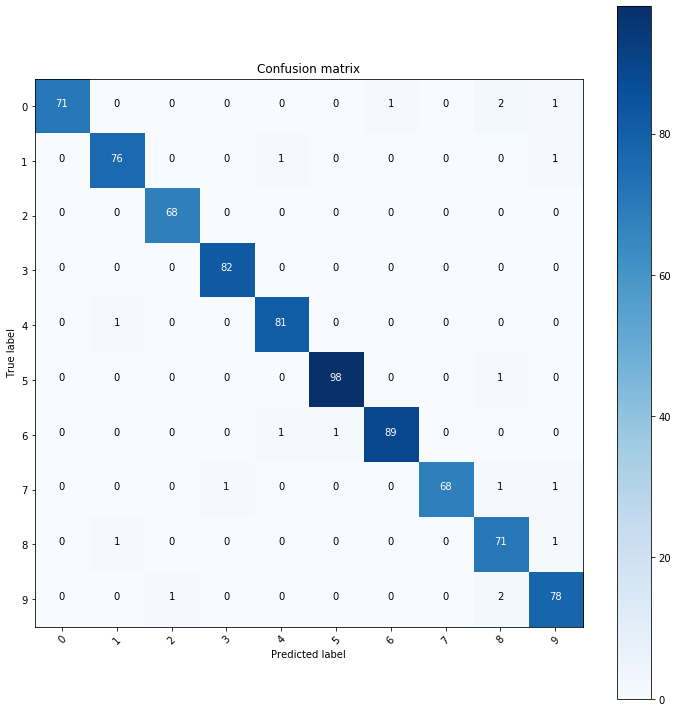

In [85]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

#### Confusion matrix for the test set

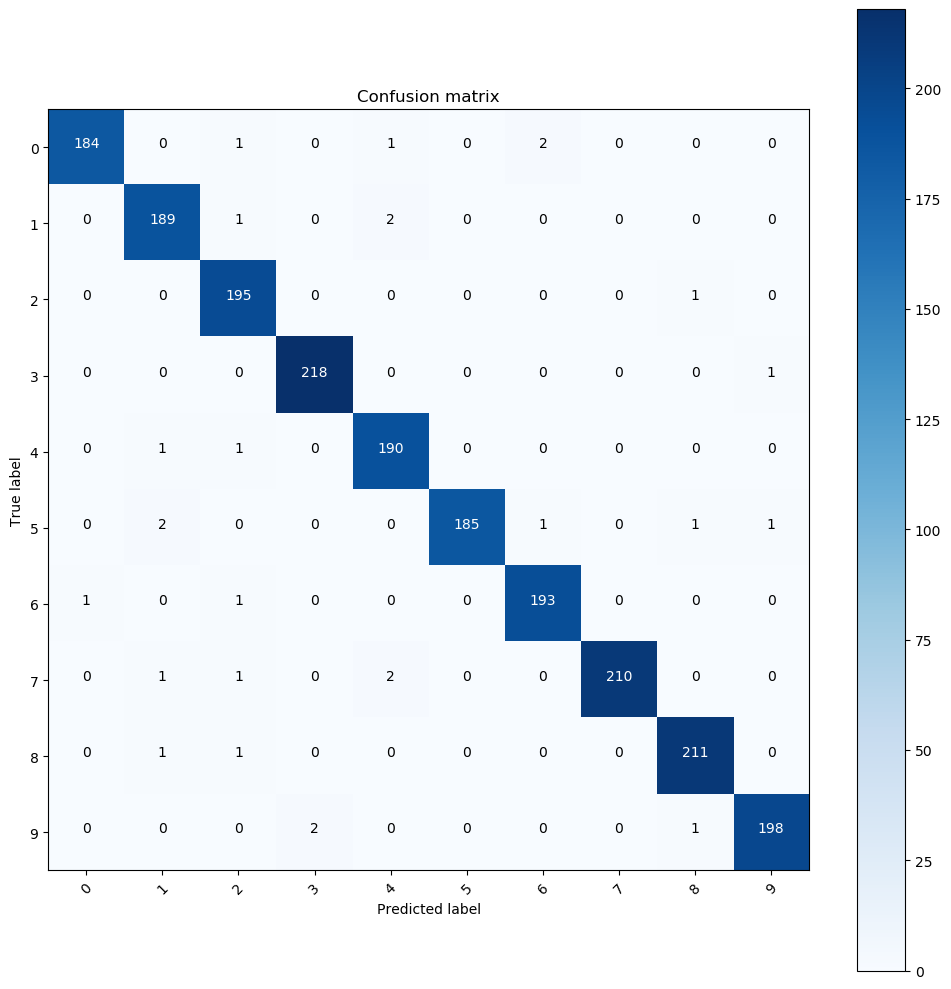

In [35]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

### Classification report

In [48]:
y_test = test.iloc[:,0].values.astype('int32')
y_test = keras.utils.to_categorical(y_test, num_classes)

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.053931, final accuracy: 0.986500


In [41]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

y_test = test.iloc[:,0].values.astype('int32')
#get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test)[0]
incorrect = np.nonzero(predicted_classes!=y_test)[0]

In [42]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99       188
     Class 1       0.97      0.98      0.98       192
     Class 2       0.97      0.99      0.98       196
     Class 3       0.99      1.00      0.99       219
     Class 4       0.97      0.99      0.98       192
     Class 5       1.00      0.97      0.99       190
     Class 6       0.98      0.99      0.99       195
     Class 7       1.00      0.98      0.99       214
     Class 8       0.99      0.99      0.99       213
     Class 9       0.99      0.99      0.99       201

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

